I want to sanity test that the mock measurements I'm comparing to are what I expect them to be, and the bad fits I'm recovering are because my models are a poor fit and not some other reason. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy as np
from os import path
from astropy.table import Table
from halotools.mock_observables import hod_from_mock
from halotools.utils import broadcast_host_halo_property, add_halo_hostid

from pearce.mocks.kittens import TrainingBox, MDPL2
import h5py

In [3]:
cat_dir = '/u/ki/swmclau2/des'

In [4]:
sham_catalog = np.load(path.join(cat_dir, 'cut_sham_catalog.npy'))

In [5]:
shuffled_sham_catalog = np.load(path.join(cat_dir, 'cut_shuffled_sham_catalog.npy'))

In [6]:
nfw_sham_catalog = np.load(path.join(cat_dir, 'cut_nfwized_sham_catalog.npy'))

In [7]:
sham_catalog.shape, shuffled_sham_catalog.shape, nfw_sham_catalog.shape

((500001,), (500000,), (500000,))

In [8]:
catalog_fname = '/u/ki/swmclau2/des/test_MDPL2_halo_vpeak_smf_sham_large.hdf5'
halo_catalog = Table.read(catalog_fname, format = 'hdf5')#, path = 'halo_vpeak_shuffled'))

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/importlib/__init__.py:37: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  __import__(name)


In [9]:
len(halo_catalog)

42615485

In [10]:
haloprop_bins = np.logspace(10,16, 61)
hbc = (haloprop_bins[1:] + haloprop_bins[:-1])/2.0

In [11]:
sham_hod, _ = hod_from_mock( sham_catalog['halo_mvir_host_halo'],halo_catalog['halo_mvir'], haloprop_bins)

In [12]:
shuffled_sham_hod, _ = hod_from_mock(shuffled_sham_catalog['halo_mvir_host_halo'],halo_catalog['halo_mvir'], haloprop_bins)

In [13]:
nfw_sham_hod, _ = hod_from_mock(nfw_sham_catalog['halo_mvir_host_halo'],halo_catalog['halo_mvir'], haloprop_bins)

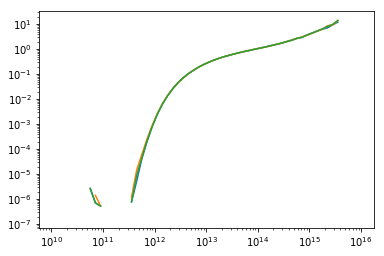

In [14]:
plt.plot(hbc, sham_hod)
plt.plot(hbc, shuffled_sham_hod)
plt.plot(hbc, nfw_sham_hod)

plt.loglog();

In [15]:
r_bins = np.logspace(-1, 1.6, 19)
rbc = (r_bins[1:]+r_bins[:-1])/2.0

In [16]:
sham_wp = np.load('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/SHAMmock_wp.npy')
shuffled_sham_wp = np.load('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/SHUFFLED_SHAMmock_wp.npy')
nfw_sham_wp = np.load('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/NFWIZED_SHAMmock_wp.npy')

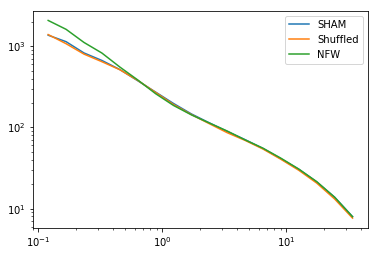

In [17]:
plt.plot(rbc, sham_wp, label ='SHAM')
plt.plot(rbc, shuffled_sham_wp, label = 'Shuffled')
plt.plot(rbc, nfw_sham_wp, label = 'NFW')
plt.loglog();
plt.legend(loc='best')

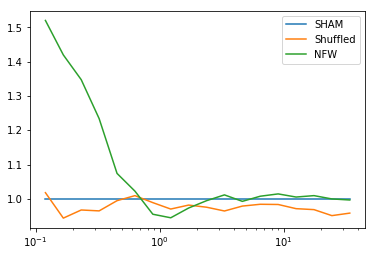

In [18]:
plt.plot(rbc, sham_wp/sham_wp, label ='SHAM')
plt.plot(rbc, shuffled_sham_wp/sham_wp, label = 'Shuffled')
plt.plot(rbc, nfw_sham_wp/sham_wp, label = 'NFW')
plt.xscale('log');
plt.legend(loc='best')

In [19]:
sham_ds = np.load('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/SHAMmock_ds.npy')
shuffled_sham_ds = np.load('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/SHUFFLED_SHAMmock_ds.npy')
nfw_sham_ds = np.load('/u/ki/swmclau2/Git/pearce/bin/mock_measurements/NFWIZED_SHAMmock_ds.npy')

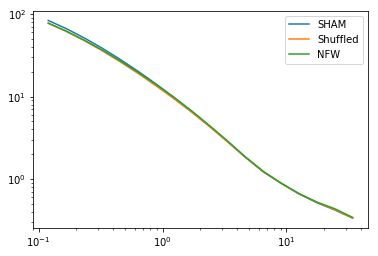

In [20]:
plt.plot(rbc, sham_ds, label ='SHAM')
plt.plot(rbc, shuffled_sham_ds, label = 'Shuffled')
plt.plot(rbc, nfw_sham_ds, label = 'NFW')
plt.loglog();
plt.legend(loc='best')

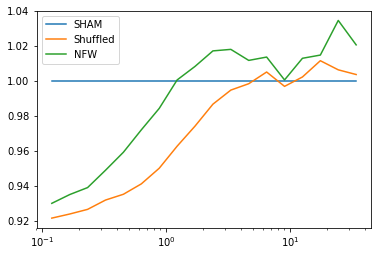

In [21]:
plt.plot(rbc, sham_ds/sham_ds, label ='SHAM')
plt.plot(rbc, shuffled_sham_ds/sham_ds, label = 'Shuffled')
plt.plot(rbc, nfw_sham_ds/sham_ds, label = 'NFW')
plt.xscale('log');
plt.legend(loc='best')

In [22]:
mdpl2 = MDPL2()

In [23]:
cat = TrainingBox(0,system='ki-ls')
cat.load_model(1.0, HOD='abZheng07')

In [24]:
mdpl2.pmass

1510000000.0

In [25]:
mass_function = np.histogram(halo_catalog[halo_catalog['halo_upid']==-1]['halo_mvir'], haloprop_bins)[0]

In [26]:
mass_function[hbc<mdpl2.pmass*100] = 0.0

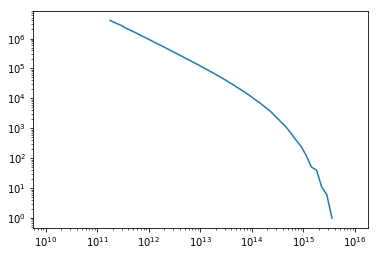

In [27]:
plt.plot(hbc, mass_function)
plt.loglog();

In [28]:
def calc_analytic_nd(cat, params, min_ptcl):
    hod = calc_hod(cat, params, hbc)
    return np.sum(mass_function * hod) / ((1000) ** 3)  # /self.h)**3)


In [29]:
from scipy.optimize import minimize_scalar, curve_fit
def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (calc_analytic_nd(cat,hod_params, min_ptcl=100) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12.0,14.0),\
                          args = (hod_params,), \
                          options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    hod_params['logMmin'] = res.x
    #print res.x,
    #print calc_analytic_nd(cat, hod_params, min_ptcl=100)


In [30]:
def calc_hod(cat, params, bin_centers):
    cat.model.param_dict.update(params)
    cens_occ, sats_occ = cat.model.model_dictionary['centrals_occupation'], cat.model.model_dictionary[
        'satellites_occupation']
    for key, val in params.iteritems():
        if key in cens_occ.param_dict:
            cens_occ.param_dict[key] = val
        if key in sats_occ.param_dict:
            sats_occ.param_dict[key] = val

    cen_hod = getattr(cens_occ, "baseline_mean_occupation", cens_occ.mean_occupation)(prim_haloprop=bin_centers)

    sat_hod = getattr(sats_occ, "baseline_mean_occupation", sats_occ.mean_occupation)(prim_haloprop=bin_centers)

    return cen_hod, sat_hod

In [85]:
chain_fname = '/u/ki/swmclau2/des/PearceMCMC/NFWizedSHAM_fixed_cosmo_wp_ds_rmin_None_CAB.hdf5'

In [86]:
f = h5py.File(chain_fname, 'r')

In [87]:
tf = f.attrs['training_file']

In [91]:
n_walkers = f.attrs['nwalkers']
chain_pnames = f.attrs['param_names']
n_burn = 10000

In [92]:
chain = f['chain'][:n_burn*n_walkers]

In [93]:
chain.shape

(1317250, 9)

In [94]:
f.close()

In [95]:
downsample_npoints = 100
downsample_idxs = np.random.choice(chain.shape[0], downsample_npoints, replace=False)

In [96]:
downsample_hod_chain = chain[downsample_idxs, 7:]

In [97]:
hod_chain_pnames = chain_pnames[7:]

In [98]:
cen_mask = sham_catalog['halo_upid'] == -1
sham_cen_hod, _ = hod_from_mock( sham_catalog['halo_mvir_host_halo'][cen_mask],halo_catalog['halo_mvir'], haloprop_bins)
sham_sat_hod, _  = hod_from_mock( sham_catalog['halo_mvir_host_halo'][~cen_mask],halo_catalog['halo_mvir'], haloprop_bins)

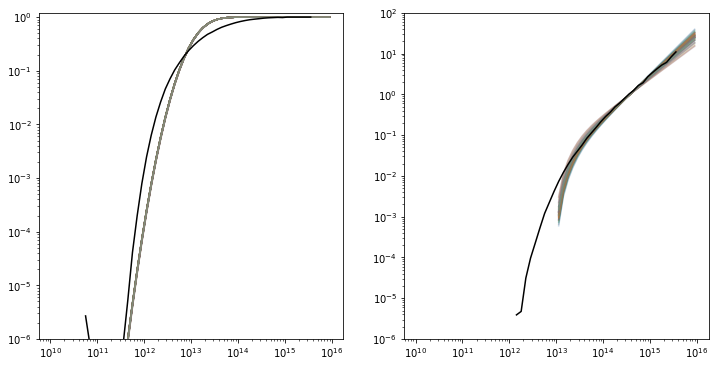

In [99]:
fig = plt.figure(figsize=(12,6) )
for point in downsample_hod_chain:
    params = dict(zip(hod_chain_pnames,point))
    add_logMmin(params, cat)

    cen_hod, sat_hod = calc_hod(cat, params , hbc)
    plt.subplot(121)
    plt.plot(hbc, cen_hod, alpha = 0.2)
    plt.subplot(122)
    plt.plot(hbc, sat_hod, alpha = 0.2)

plt.subplot(121)
plt.plot(hbc, sham_cen_hod, color ='k')#, ls = ':')
plt.ylim([1e-6, 1.2])
plt.loglog();
plt.subplot(122)
plt.plot(hbc, sham_sat_hod, color = 'k')#, ls = '--')
plt.ylim([1e-6, 1e2])
plt.loglog();
plt.show();

In [100]:
def cen_hod(hbc, sigma_logM, logMmin, full_range = False):
    params = {'sigma_logM': sigma_logM, 'logMmin': logMmin}
    cat.model.param_dict.update(params)
    
    cens_occ = cat.model.model_dictionary['centrals_occupation']
    
    for key, val in params.iteritems():
        if key in cens_occ.param_dict:
            cens_occ.param_dict[key] = val
            
    cen_hod = getattr(cens_occ, "baseline_mean_occupation", cens_occ.mean_occupation)(prim_haloprop=hbc)
    #sat_hod = getattr(sats_occ, "baseline_mean_occupation", sats_occ.mean_occupation)(prim_haloprop=bin_centers)
    if full_range:
        return cen_hod
    
    return np.log10(cen_hod[15:-4])

In [101]:
def sat_hod(hbc, alpha, logM0, logM1, full_range = False):
    params = {'alpha': alpha, 'logM0': logM0, 'logM1': logM1}
    params.update( {'sigma_logM': t[0], 'logMmin': t[1]})
    cat.model.param_dict.update(params)
    sats_occ = cat.model.model_dictionary['satellites_occupation']
    cens_occ, sats_occ = cat.model.model_dictionary['centrals_occupation'], cat.model.model_dictionary[
        'satellites_occupation']
    for key, val in params.iteritems():
        if key in cens_occ.param_dict:
            cens_occ.param_dict[key] = val
        if key in sats_occ.param_dict:
            sats_occ.param_dict[key] = val
                
    sat_hod = getattr(sats_occ, "baseline_mean_occupation", sats_occ.mean_occupation)(prim_haloprop=hbc)

    if full_range:
        return sat_hod
    return sat_hod[:-4]

In [102]:
t = curve_fit(cen_hod, hbc, np.log10(sham_cen_hod[15:-4]), p0 = [0.5, 13.5])[0]
print t

[ 0.44415222 13.00041516]


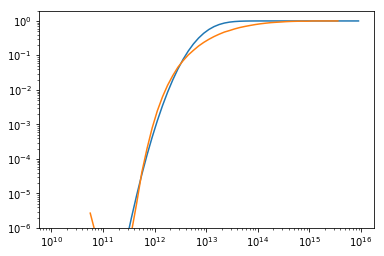

In [103]:
plt.plot(hbc, cen_hod(hbc, *t, full_range=True))
plt.plot(hbc, sham_cen_hod)
plt.ylim([1e-6, 2])
plt.loglog();

In [104]:
t2 = curve_fit(sat_hod, hbc,sham_sat_hod[:-4], p0 = [0.9, 13.3, 14.5])[0]
print t2

[ 1.03887678 11.4103911  14.56088753]


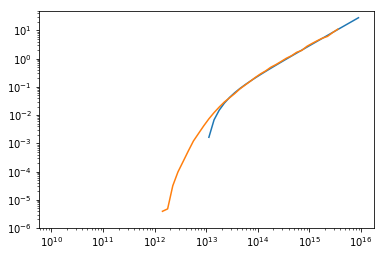

In [105]:
plt.plot(hbc, sat_hod(hbc, 1.038, 13.0, 14.56, full_range=True))
plt.plot(hbc, sham_sat_hod)
plt.ylim([1e-6, 50])
plt.loglog();

In [106]:
from pearce.emulator import LemonPepperWet
emus = []
for tmp in tf:
    print tmp
    emus.append(LemonPepperWet(tmp, fixed_params = {'z':0.0}, hyperparams = {}) )

/u/ki/swmclau2/des/Aemulators/wp_cab/PearceWpCABCosmo.hdf5
/u/ki/swmclau2/des/Aemulators/ds_cab/PearceDsCABCosmo.hdf5


In [107]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [108]:
hod_pnames = ['sigma_logM', 'logM0', 'logM1', 'alpha', 'conc_gal_bias',\
              'mean_occupation_centrals_assembias_param1',\
              'mean_occupation_satellites_assembias_param1',
             'mean_occupation_centrals_assembias_slope1',\
              'mean_occupation_satellites_assembias_slope1']
#hod_true_vals = [t[0], 12.5, t2[2], t2[0], 1.0, 0.0, 0.0, 1.0, 1.0]
#hod_true_vals = [0.2, 13.2, 14.5, 0.95, 1.0, 0.0, 0.0, 1.0, 1.0]

In [118]:
chain.mean(axis = 0)

array([ 1.2696622e-02,  5.2345026e-02,  1.3117433e+01,  3.9001119e-01,
       -1.1701156e-02, -7.6655008e-02,  1.4651330e+01,  1.0074642e+00,
        9.2843473e-01], dtype=float32)

In [109]:
hod_true_vals

[0.2, 13.2, 14.5, 0.95, 1.0, 0.0, 0.0, 1.0, 1.0]

In [119]:
true_param_dict = cat_val_dict
#true_param_dict.update(dict(zip(hod_pnames, hod_true_vals)))
true_param_dict.update(zip(chain_pnames, chain.mean(axis=0)))

In [120]:
emu_wp = emus[0].emulate_wrt_r(true_param_dict).squeeze()

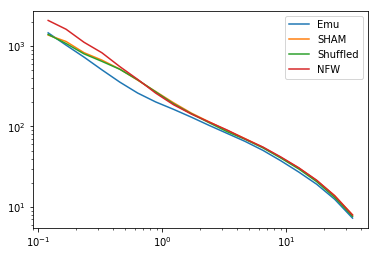

In [121]:
plt.plot(rbc, (10**emu_wp), label = 'Emu')
plt.plot(rbc, sham_wp, label ='SHAM')
plt.plot(rbc, shuffled_sham_wp, label = 'Shuffled')
plt.plot(rbc, nfw_sham_wp, label = 'NFW')
plt.loglog();
plt.legend(loc='best')

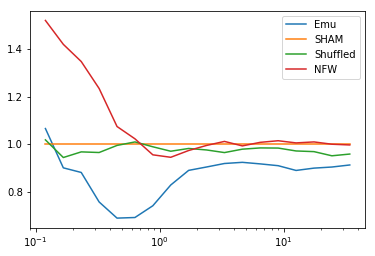

In [122]:
plt.plot(rbc, (10**emu_wp)/sham_wp, label = 'Emu')
plt.plot(rbc, sham_wp/sham_wp, label ='SHAM')
plt.plot(rbc, shuffled_sham_wp/sham_wp, label = 'Shuffled')
plt.plot(rbc, nfw_sham_wp/sham_wp, label = 'NFW')
plt.xscale('log');
plt.legend(loc='best')

In [123]:
emu_ds = emus[1].emulate_wrt_r(true_param_dict).squeeze()

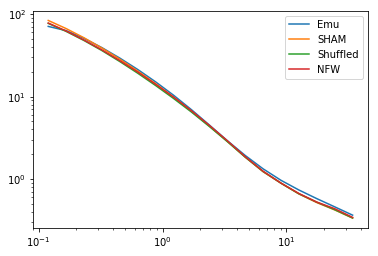

In [124]:
plt.plot(rbc, (10**emu_ds), label = 'Emu')
plt.plot(rbc, sham_ds, label ='SHAM')
plt.plot(rbc, shuffled_sham_ds, label = 'Shuffled')
plt.plot(rbc, nfw_sham_ds, label = 'NFW')
plt.loglog();
plt.legend(loc='best')

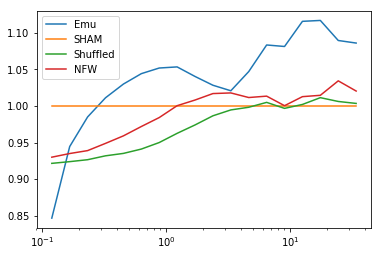

In [125]:
plt.plot(rbc, (10**emu_ds)/sham_ds, label = 'Emu')
plt.plot(rbc, sham_ds/sham_ds, label ='SHAM')
plt.plot(rbc, shuffled_sham_ds/sham_ds, label = 'Shuffled')
plt.plot(rbc, nfw_sham_ds/sham_ds, label = 'NFW')
plt.xscale('log');
plt.legend(loc='best')